In [136]:
import numpy as np
import pandas as pd
import os
import openpyxl
import tensorflow as tf
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from tensorflow.keras.layers import LSTM,Dense,GRU,Dropout,SimpleRNN
from sklearn.metrics import mean_squared_error
# from keras.callbacks import EarlyStopping, ModelCheckpoint
import random as rn

# SEED 값 설정

In [137]:
seed_num =5
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)

# series_to_supervised 함수 설정

In [138]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [139]:
n_hours = 3
n_features = 43
data_num = len(df)
train_num_15 = 1444
train_num_16 = 1649
train_num_17 = 1774
train_num_18 = 1839
train_num_19 = 1934
train_num_20 = 2197
train_num_21 = 2282
train_num_22 = 2567
train_num_23 = 2695
train_num_24 = 2789
train_num_25 = 2891
test_num = 160
print(data_num)

3051


In [140]:
from os.path import join
df = pd.read_excel('rain_data.xlsx')
df.head()
df.tail()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 38,Unnamed: 39,Unnamed: 40,데이터 집단 6,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47
3046,26,2018,7,7,17,NaN,2.3689,1,0,0,...,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.95
3047,26,2018,7,7,18,NaN,2.3689,1,0,0,...,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.97
3048,26,2018,7,7,19,NaN,2.3689,1,0,0,...,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.98
3049,26,2018,7,7,20,NaN,2.3689,1,0,0,...,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.99
3050,26,2018,7,7,21,NaN,2.3689,1,0,0,...,0,3.10,129.964,1.8810,1,0,0,0,3.10,130.00


# df_matrix 만드는 과정? 
# scaling

In [141]:
# df_metrix 만드는 과정
df_matrix = df.to_numpy()
df_test_matrix = df.to_numpy()


df_matrix = df_matrix[0:train_num_25, 5:]
df_test_matrix = df_test_matrix[train_num_25:,5:]

print(df_matrix.shape)
print(df_matrix)
print("========================================================================")
print(df_test_matrix.shape)
print(df_test_matrix)
df_matrix = df_matrix.astype('float32')
df_test_matrix = df_test_matrix.astype('float32')


# scaler = MinMaxScaler(feature_range=(0, 1))
# df_matrix = scaler.fit_transform(df_matrix)
# df_test_matrix = scaler.fit_transform(df_test_matrix)

(2891, 43)
[[189.1         6.4         7.        ...   8.          2.54
  122.61     ]
 [216.9519618   6.3         7.        ...  10.          2.53
  122.6      ]
 [251.4244187   6.4         7.        ...  11.          2.53
  122.59     ]
 ...
 [491.9548045   4.1089      1.        ...   1.          2.98
  137.155    ]
 [481.1030831   3.3854      1.        ...   1.          2.96
  137.165    ]
 [470.4581089   3.2841      1.        ...   1.          2.94
  137.18     ]]
(160, 43)
[[     nan  14.2576  32.     ...   0.       1.93   120.515 ]
 [     nan  10.9657  20.     ...   8.       1.93   120.51  ]
 [     nan   7.9442  11.     ...  24.       1.92   120.505 ]
 ...
 [     nan   2.3689   1.     ...   0.       3.13   129.98  ]
 [     nan   2.3689   1.     ...   0.       3.11   129.99  ]
 [     nan   2.3689   1.     ...   0.       3.1    130.    ]]


# 26 번 유입량 nan 값을 -1 로 일단 넣는 작업 진행

In [144]:
print(df_test_matrix[:,0])
df_test_matrix[:,0] = -1
print(df_test_matrix[:,0])
print(df_test_matrix[:,0].shape)

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -

# lag 만들어서 하는거 

In [155]:
# print(df_matrix)
lag = series_to_supervised(df_matrix, n_hours,1)
lag_test = series_to_supervised(df_test_matrix, n_hours,1)

lag = lag.values
lag_test = lag_test.values
print("lag")
print(lag.shape)
print(lag)
print("lag_test")
print(lag_test.shape)
print(lag_test)
print("00000000000000000000000000000000000000000000000000000000")
tmp = lag.shape[1]-42
tmp_test = lag_test.shape[1]-42
print("tmp")
print(tmp)
print("tmp_test")
print(tmp_test)
lag = lag[:,0:tmp]
lag_test = lag_test[:,:tmp_test]
print("111111111111111111111111111111111111111111111111111111111")
print(lag.shape)
print(lag)
print("222222222222222222222222222222222222222222222222222222222")
print(lag_test.shape)
print(type(lag_test))
print(lag_test)

lag
(2888, 172)
[[189.1       6.4       7.      ...  14.        2.53    122.585  ]
 [216.95197   6.3       7.      ...  16.        2.53    122.575  ]
 [251.42442   6.4       7.      ...  17.        2.53    122.565  ]
 ...
 [522.98944  36.5129   10.      ...   1.        2.98    137.155  ]
 [513.3684   22.7836    6.      ...   1.        2.96    137.165  ]
 [502.84683   8.2586    2.      ...   1.        2.94    137.18   ]]
lag_test
(157, 172)
[[ -1.      14.2576  32.     ...  33.       1.92   120.5   ]
 [ -1.      10.9657  20.     ...  36.       1.92   120.495 ]
 [ -1.       7.9442  11.     ...  37.       1.95   120.49  ]
 ...
 [ -1.       2.4298   1.     ...   0.       3.13   129.98  ]
 [ -1.       2.3689   1.     ...   0.       3.11   129.99  ]
 [ -1.       2.3689   1.     ...   0.       3.1    130.    ]]
00000000000000000000000000000000000000000000000000000000
tmp
130
tmp_test
130
111111111111111111111111111111111111111111111111111111111
(2888, 130)
[[189.1       6.4       7.      ... 

# 이제 test 유입량에 -1 이 들어가 있는 상태였는데,,,, 
다시 nan 값으로 변경 해 줘야되지 않나? 



In [157]:
# lag_test = lag_test.replace(-1, np.NaN)
# print(lag_test)

In [158]:
n_train_hours = train_num_23

train = lag[:n_train_hours, :]
print("*****train*****")
print(train.shape)
print(train)
val = lag[n_train_hours:, :]

print("\n*****validation*****")

print(val.shape)
print(val)

test = lag_test
print("*****test*****")
print(lag_test)
print("\n*****data_num*****")
print(data_num)

print("\n*****n_train_hours*****")
print(n_train_hours)
# print(n_test_hours)
# test = lag[:,:]
print("\n*****train.sahpe*****")
print(train.shape)
print("\n*****val.shape*****")
print(val.shape)
print("*****test.shape***** ")
print(lag_test.shape)

*****train*****
(2695, 130)
[[1.8910001e+02 6.4000001e+00 7.0000000e+00 ... 2.5300000e+00
  1.2259000e+02 3.0281219e+02]
 [2.1695197e+02 6.3000002e+00 7.0000000e+00 ... 2.5300000e+00
  1.2258500e+02 3.8478342e+02]
 [2.5142442e+02 6.4000001e+00 7.0000000e+00 ... 2.5300000e+00
  1.2257500e+02 5.1250122e+02]
 ...
 [1.3790315e+03 3.9775101e+01 5.2000000e+01 ... 1.0700001e+00
  1.1870000e+02 6.3941368e+01]
 [1.3531034e+03 3.9184299e+01 5.1000000e+01 ... 1.0700001e+00
  1.1870000e+02 6.4593552e+01]
 [4.9907669e+01 1.7965000e+00 3.0000000e+00 ... 1.0700001e+00
  1.1870000e+02 5.5622105e+01]]

*****validation*****
(193, 130)
[[ 63.94137    1.3606     3.       ...   1.07     118.7       44.23353 ]
 [ 64.59355    1.3135     2.       ...   1.07     118.7       37.056877]
 [ 55.622105   1.3608     0.       ...   1.07     118.7       38.166542]
 ...
 [522.98944   36.5129    10.       ...   3.       137.145    491.9548  ]
 [513.3684    22.7836     6.       ...   2.98     137.155    481.1031  ]
 [502

# train_X, train_y

### train_X 
유입량, 유역평균강수 등 을 정상적으로 표현을 하고 있는거 같음. 
### train_y


# val_X, val_y


In [160]:
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
val_X, val_y = val[:, :n_obs], val[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
print("train_X")
print(train_X)
print("train_y")
print(train_y)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(2695, 129) 2695 (2695,)
train_X
[[1.8910001e+02 6.4000001e+00 7.0000000e+00 ... 1.1000000e+01
  2.5300000e+00 1.2259000e+02]
 [2.1695197e+02 6.3000002e+00 7.0000000e+00 ... 1.4000000e+01
  2.5300000e+00 1.2258500e+02]
 [2.5142442e+02 6.4000001e+00 7.0000000e+00 ... 1.6000000e+01
  2.5300000e+00 1.2257500e+02]
 ...
 [1.3790315e+03 3.9775101e+01 5.2000000e+01 ... 0.0000000e+00
  1.0700001e+00 1.1870000e+02]
 [1.3531034e+03 3.9184299e+01 5.1000000e+01 ... 0.0000000e+00
  1.0700001e+00 1.1870000e+02]
 [4.9907669e+01 1.7965000e+00 3.0000000e+00 ... 0.0000000e+00
  1.0700001e+00 1.1870000e+02]]
train_y
[6.4    7.3    8.2    ... 1.7965 1.3606 1.3135]
(2695, 3, 43) (2695,) (193, 3, 43) (193,)


In [112]:
# testing
model = tf.keras.Sequential()
# model.add(GRU(units = 50,
#               # dropout =0.2,
#               return_sequences = True,
#               input_shape = (train_X.shape[1],train_X.shape[2]),
#               activation = 'tanh'))

# model.add(SimpleRNN(50))
model.add(LSTM(20, input_shape = (train_X.shape[1],train_X.shape[2]), activation = 'tanh', return_sequences = False))
model.add(Dense(1))

In [11]:
adam = tf.keras.optimizers.Adam(lr =0.0001)
model.compile(loss='mse', optimizer='adam')

history = model.fit(train_X, train_y, 
                                    epochs=50, 
                                    batch_size=32,
                                    validation_data=(val_X, val_y))

pred = model.predict(val_X)

Epoch 1/50
85/85 [==============================] - 1s 6ms/step - loss: 0.0060 - val_loss: 8.2675e-04
Epoch 2/50
85/85 [==============================] - 0s 2ms/step - loss: 7.1449e-04 - val_loss: 5.9896e-04
Epoch 3/50
85/85 [==============================] - 0s 2ms/step - loss: 4.2646e-04 - val_loss: 4.9058e-04
Epoch 4/50
85/85 [==============================] - 0s 2ms/step - loss: 3.1884e-04 - val_loss: 4.3173e-04
Epoch 5/50
85/85 [==============================] - 0s 2ms/step - loss: 2.6012e-04 - val_loss: 4.0605e-04
Epoch 6/50
85/85 [==============================] - 0s 2ms/step - loss: 2.3133e-04 - val_loss: 3.8813e-04
Epoch 7/50
85/85 [==============================] - 0s 2ms/step - loss: 2.0498e-04 - val_loss: 3.3603e-04
Epoch 8/50
85/85 [==============================] - 0s 2ms/step - loss: 1.7687e-04 - val_loss: 3.1410e-04
Epoch 9/50
85/85 [==============================] - 0s 2ms/step - loss: 1.5870e-04 - val_loss: 3.1669e-04
Epoch 10/50
85/85 [==============================]

In [12]:
RMSE = mean_squared_error(val_y,pred)**0.5
print(RMSE)
# 0.0008423473487552474
# 19 0.006666403945529522
# 22 0.005604106434524586
# 23 0.00430284683384523
# 24 0.005179650254020364

0.00430284683384523


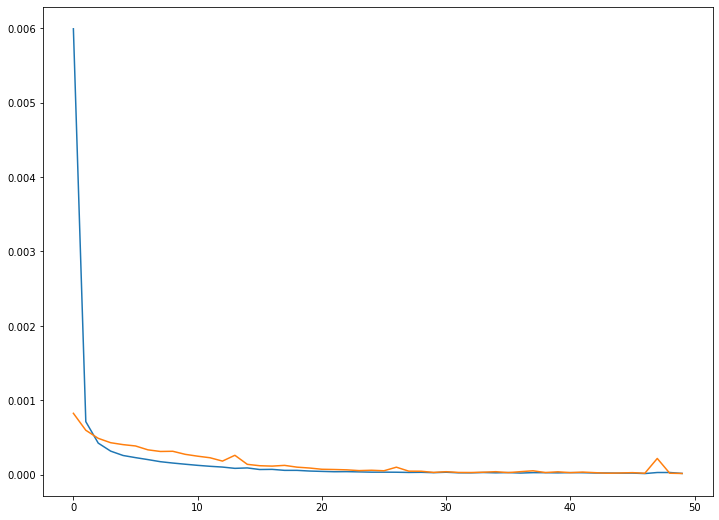

In [13]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'], label = 'test')

plt.show()

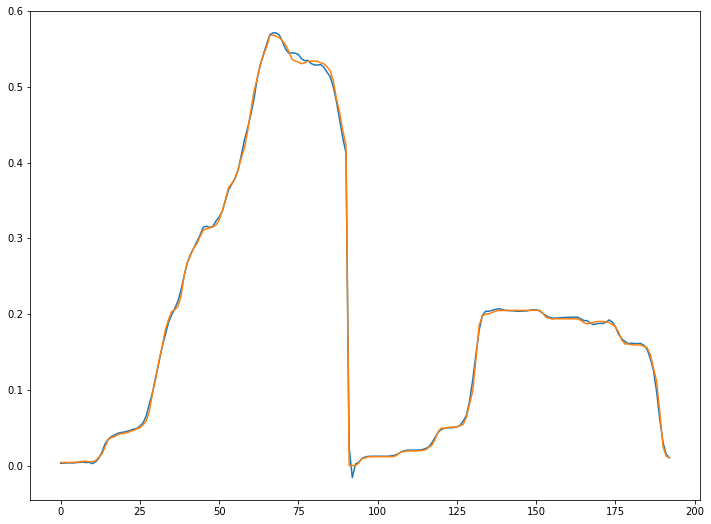

In [14]:
plt.figure(figsize=(12, 9))
plt.plot(pred,label='prediction')
plt.plot(val_y,label='real')
plt.show()